In [91]:
!pip install tensorflow pillow

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
%cd /content/drive/MyDrive/SCAI_Neural_Network_Project/yolo_dataset
%ls

/content/drive/MyDrive/SCAI_Neural_Network_Project/yolo_dataset
combined_test.tfrecord   images/      new_model1_test.keras
combined_train.tfrecord  labels/      new_model.keras
combined_val.tfrecord    mode1.keras  TrainDetectionModel.ipynb
extracted_folder/        new_model1/


In [ ]:
# Import the required libraries
import os
import tensorflow as tf
from PIL import Image
import io
import numpy as np
from tensorflow.keras.saving import register_keras_serializable

In [93]:
train_labels_directory = "labels/combined_train"
train_images_directory = "images/combined_train"

val_labels_directory = "labels/combined_valid"
val_images_directory = "images/combined_valid"

test_labels_directory = "labels/combined_test"
test_images_directory = "images/combined_test"

LABEL_MAP_DICT ={
    0: "no_gloves",
    1: "has_gloves"
    }

IMAGE_FORMAT = "jpg"
IMAGE_FORMAT_2 = "png"

In [ ]:
def create_tf_example(image_directory, label_directory, format):
  with tf.io.gfile.GFile(os.path.join(image_directory), 'rb') as fid:
    encoded_jpg = fid.read()
  image = Image.open(io.BytesIO(encoded_jpg))
  width, height = image.size
  filename = image_directory.split('/')[-1].encode('utf8')
  image_format = ""
  if format== IMAGE_FORMAT:
    image_format = IMAGE_FORMAT.encode('utf8')
  elif format == IMAGE_FORMAT_2:
    image_format = IMAGE_FORMAT_2.encode('utf8')
  else:
    raise ValueError("Image format not recognized.")
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  classes_text = []
  classes = []
  with open(label_directory, 'r') as label_file:
    for line in label_file.readlines():
      class_id, x_center, y_center, bound_width, bound_height = map(float, line.strip().split())
      xmin = (x_center - bound_width / 2) * width
      xmax = (x_center + bound_width / 2) * width
      ymin = (y_center - bound_height / 2) * height
      ymax = (y_center + bound_height / 2) * height

      xmins.append(xmin / width)
      xmaxs.append(xmax / width)
      ymins.append(ymin / height)
      ymaxs.append(ymax / height)

      class_id = int(class_id)
      classes_text.append(LABEL_MAP_DICT[class_id].encode('utf8'))
      classes.append(class_id + 1)

  tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        }))
  return tf_example




In [ ]:
# CREATE RECORDS FOR TRAINING DATA
##########################################################

#For each file, create an encoded representating incorporating both the image and the bounding labels
writer = tf.io.TFRecordWriter("combined_train.tfrecord")

intended_directory = train_labels_directory

num_files = len(os.listdir(intended_directory))
index = 0

#pick which image/ label to use: train, val, or test.
for label_file in os.listdir(intended_directory):
  label_path = os.path.join(intended_directory, label_file)
  if not label_file.endswith(".txt"):
    continue
  image_file_jpg = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT
  image_path_jpg = os.path.join(train_images_directory, image_file_jpg)

  image_file_png = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT_2
  image_path_png = os.path.join(train_images_directory, image_file_png)

  label_path = os.path.join(train_labels_directory, label_file)

  format = IMAGE_FORMAT
  if os.path.exists(image_path_jpg):
    image_path = image_path_jpg
  elif os.path.exists(image_path_png):
    image_path = image_path_png
    format = IMAGE_FORMAT_2
  else:
    print(f"Image file not found: {image_path_jpg} or {image_path_png}")
    continue


  tf_example = create_tf_example(image_path, label_path, format)
  writer.write(tf_example.SerializeToString())
  index += 1
  print(f"Processed {index}/{num_files} files") if index % 10 == 0 else None

writer.close()
print("tf record saved to combined_train.tfrecord")

##########################################################



"""
# CREATE RECORDS FOR VALIDATION DATA
##########################################################

#For each file, create an encoded representating incorporating both the image and the bounding labels
writer = tf.io.TFRecordWriter("combined_val.tfrecord")

intended_directory = val_labels_directory

num_files = len(os.listdir(intended_directory))
index = 0

#pick which image/ label to use: train, val, or test.
for label_file in os.listdir(intended_directory):
  label_path = os.path.join(val_labels_directory, label_file)
  if not label_file.endswith(".txt"):
    continue
  image_file = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT
  image_path = os.path.join(val_images_directory, image_file)
  label_path = os.path.join(val_labels_directory, label_file)


  if not os.path.exists(image_path):
    print(f"Image file not found: {image_path}")
    continue

  tf_example = create_tf_example(image_path, label_path)
  writer.write(tf_example.SerializeToString())
  index += 1
  print(f"Processed {index}/{num_files} files") if index % 10 == 0 else None

writer.close()
print("tf record saved to combined_val.tfrecord")

##########################################################





# CREATE RECORDS FOR TEST DATA
##########################################################

#For each file, create an encoded representating incorporating both the image and the bounding labels
writer = tf.io.TFRecordWriter("combined_test.tfrecord")

intended_directory = test_labels_directory

num_files = len(os.listdir(intended_directory))
index = 0

#pick which image/ label to use: train, val, or test.
for label_file in os.listdir(intended_directory):
  label_path = os.path.join(test_labels_directory, label_file)
  if not label_file.endswith(".txt"):
    continue
  image_file = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT
  image_path = os.path.join(test_images_directory, image_file)
  label_path = os.path.join(test_labels_directory, label_file)


  if not os.path.exists(image_path):
    print(f"Image file not found: {image_path}")
    continue

  tf_example = create_tf_example(image_path, label_path)
  writer.write(tf_example.SerializeToString())
  index += 1
  print(f"Processed {index}/{num_files} files")

writer.close()
print("tf record saved to combined_test.tfrecord")

##########################################################
"""

Processed 10/3875 files
Processed 20/3875 files
Processed 30/3875 files
Processed 40/3875 files
Processed 50/3875 files
Processed 60/3875 files
Processed 70/3875 files
Processed 80/3875 files
Processed 90/3875 files
Processed 100/3875 files
Processed 110/3875 files
Processed 120/3875 files
Processed 130/3875 files
Processed 140/3875 files
Processed 150/3875 files
Processed 160/3875 files
Processed 170/3875 files
Processed 180/3875 files
Processed 190/3875 files
Processed 200/3875 files
Processed 210/3875 files
Processed 220/3875 files
Processed 230/3875 files
Processed 240/3875 files
Processed 250/3875 files
Processed 260/3875 files
Processed 270/3875 files
Processed 280/3875 files
Processed 290/3875 files
Processed 300/3875 files
Processed 310/3875 files
Processed 320/3875 files
Processed 330/3875 files
Processed 340/3875 files
Processed 350/3875 files
Processed 360/3875 files
Processed 370/3875 files
Processed 380/3875 files
Processed 390/3875 files
Processed 400/3875 files
Processed

'\n# CREATE RECORDS FOR VALIDATION DATA\n##########################################################\n\n#For each file, create an encoded representating incorporating both the image and the bounding labels\nwriter = tf.io.TFRecordWriter("combined_val.tfrecord")\n\nintended_directory = val_labels_directory\n\nnum_files = len(os.listdir(intended_directory))\nindex = 0\n\n#pick which image/ label to use: train, val, or test.\nfor label_file in os.listdir(intended_directory):\n  label_path = os.path.join(val_labels_directory, label_file)\n  if not label_file.endswith(".txt"):\n    continue\n  image_file = os.path.splitext(label_file)[0] + "." + IMAGE_FORMAT\n  image_path = os.path.join(val_images_directory, image_file)\n  label_path = os.path.join(val_labels_directory, label_file)\n\n\n  if not os.path.exists(image_path):\n    print(f"Image file not found: {image_path}")\n    continue\n\n  tf_example = create_tf_example(image_path, label_path)\n  writer.write(tf_example.SerializeToString())

In [ ]:
def parse_tfrecord(record_input):
  feature = {
      'image/encoded': tf.io.FixedLenFeature([], tf.string),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32)
        }
  parsed_record = tf.io.parse_single_example(record_input, feature)
  print(parsed_record)

  image = tf.image.decode_jpeg(parsed_record['image/encoded'],channels=3)
  image = tf.image.resize(image, [256, 256]) / 255.0

  bounding_boxes = tf.stack([
    tf.sparse.to_dense(parsed_record['image/object/bbox/ymin']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/xmin']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/ymax']),
    tf.sparse.to_dense(parsed_record['image/object/bbox/xmax'])
  ], axis=1)


  return image, bounding_boxes

In [ ]:
def load_dataset(record_path, batch_size, shuffle = False):
  dataset = tf.data.TFRecordDataset(record_path)
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
  if shuffle:
    dataset = dataset.shuffle(512)
  dataset = dataset.padded_batch(batch_size, padded_shapes=([256, 256, 3], [None, 4]))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = load_dataset("combined_train.tfrecord", 16, shuffle = True)
val_dataset = load_dataset("combined_val.tfrecord", 16)
test_dataset = load_dataset("combined_test.tfrecord", 16)

{'image/object/bbox/xmax': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:4", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:8", shape=(1,), dtype=int64)), 'image/object/bbox/xmin': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:5", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:9", shape=(1,), dtype=int64)), 'image/object/bbox/ymax': SparseTensor(indices=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:2", shape=(None, 1), dtype=int64), values=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:6", shape=(None,), dtype=float32), dense_shape=Tensor("ParseSingleExample/ParseExample/ParseExampleV2:10", shape=(1,), dtype=int64)), 'i

In [ ]:
@register_keras_serializable()
class detector(tf.keras.Model):
  def __init__(self):
    super(detector, self).__init__()
    self.backbone = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 2, strides = 1, activation = 'relu', padding= 'same'),
        #tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 2, strides = 1, activation = 'relu', padding= 'same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 2, strides = 1, activation = 'relu', padding= 'same'),
        #tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 2, strides = 1, activation = 'relu', padding= 'same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Conv2D(512, 2, strides = 1, activation = 'relu', padding= 'same'),
        #tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(1024, 2, strides = 1, activation = 'relu', padding= 'same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    self.box_head = tf.keras.layers.Dense(4, activation = 'sigmoid')
  def call(self, x):
    return self.box_head(self.backbone(x))

def loss_fn(bboxes_true, box_preds):
    return tf.reduce_mean(tf.square(bboxes_true[:, 0] - box_preds))


In [ ]:
model = detector()
model.compile(optimizer = 'adam', loss = loss_fn)

num_images = 3875
batch_size = 16
steps_per_epoch = num_images // batch_size

model.fit(train_dataset,validation_data=val_dataset, epochs = 70, steps_per_epoch = steps_per_epoch)

Epoch 1/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 115s 461ms/step - loss: 0.0249 - val_loss: 0.0191
Epoch 2/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 3/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 111s 402ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 4/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0119 - val_loss: 0.0174
Epoch 5/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 142s 584ms/step - loss: 0.0160 - val_loss: 0.0135
Epoch 6/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 7/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 202s 614ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 8/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0058 - val_loss: 0.0142
Epoch 9/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 143s 402ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 10/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0185 - val_loss: 0.0115
Epoch 11/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 135s 401ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 12/70
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0065 - val_loss: 0.0105
Epoch 13/70
242/242 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
model.export("new_model1")
#!unzip mode1.keras -d extracted_folder/
#!ls

Saved artifact at 'new_model1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140652262595024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140654555952720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140654555941008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652262594832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652262595792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652262595600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140654555948688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140654555953488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652261698704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652261697360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140652261699088: TensorSpec(sh

In [ ]:
#model = detector()
#model.build(input_shape = (None, 256, 256, 3))
#print(os.path.exists("extracted_folder/model.weights.h5"))
#model.load_weights("extracted_folder/model.weights.h5")  # load trained weights
#model.save("new_model.keras")

# add more dropouts. looks like the model is starting to memorize the the data
print("evaluating the dataset")
result = model.evaluate(test_dataset)
print(result)

evaluating the dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0048
0.004785992205142975


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
def compute_dist(box1, box2):
  ymin1, xmin1, ymax1, xmax1 = box1
  ymin2, xmin2, ymax2, xmax2 = box2
  print(f"computing differences between {box1} and {box2}.")

  dist = (xmax1 - xmin1) * (ymax1 - ymin1) + (xmax2 - xmin2) * (ymax2 - ymin2) - (xmax2 - xmin2) * (ymax2 - ymin2)

  return dist

def compute_iou(box1, box2):
  ymin1, xmin1, ymax1, xmax1 = box1
  ymin2, xmin2, ymax2, xmax2 = box2
  print(f"computing differences between {box1} and {box2}.")

  xi1 = max(xmin1, xmin2)
  yi1 = max(ymin1, ymin2)
  xi2 = min(xmax1, xmax2)
  yi2 = min(ymax1, ymax2)

  intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

  box1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
  box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)

  union_area = box1_area + box2_area - intersection_area

  iou = intersection_area / union_area if union_area > 0 else 0.0

  #if iou <= 0.0:
    # if the boxes do not overlap at all
  #  return compute_dist(box1, box2)

  return iou


In [ ]:
num_images = len(os.listdir(test_images_directory))
computed_ious = 0.0
index = 0
for test_image in os.listdir(test_images_directory):
  if (test_image.endswith(".png")) or (test_image.endswith(".jpg")) or (test_image.endswith(".jpeg")):
    print("Image is of correct type")
  else:
    continue
  img = Image.open(os.path.join(test_images_directory, test_image)).convert("RGB")
  img = img.resize((256,256))
  input_tensor = tf.convert_to_tensor(np.array(img)/255.0, dtype = tf.float32)
  input_tensor = tf.expand_dims(input_tensor, axis = 0)

  pred_bounds = model(input_tensor)
  pred_bounds = pred_bounds[0].numpy()

  img_width, img_height = img.size
  ymin, xmin, ymax, xmax = pred_bounds

  (ymin, xmin, ymax, xmax) = (int(ymin * img_height), int(xmin * img_width), int(ymax * img_height), int(xmax * img_width))

  normalized_bounds = (ymin, xmin, ymax, xmax)

  test_labels = test_image.replace(".jpg", ".txt")
  if test_labels not in os.listdir(test_labels_directory):
    test_labels = test_image.replace(".jpeg", ".txt")

  label_directory = os.path.join(test_labels_directory, test_labels)
  #print(label_directory)

  with open(label_directory, 'r') as label_file:
    for line in label_file.readlines():
      class_id, x_center, y_center, bound_width, bound_height = map(float, line.strip().split())
      xmin_actual = (x_center - bound_width / 2) * img_width
      xmax_actual = (x_center + bound_width / 2) * img_width
      ymin_actual = (y_center - bound_height / 2) * img_height
      ymax_actual = (y_center + bound_height / 2) * img_height
      actual_bounds =  (int(ymin_actual), int(xmin_actual), int(ymax_actual), int(xmax_actual))
      iou = compute_iou(normalized_bounds,actual_bounds)
      print(f"Current IOU: {iou * 100:.2f}%")
      computed_ious += iou
      index += 1
average_iou = computed_ious / index
print(f"\nAverage IOU: {average_iou * 100:.2f}%")


Image is of correct type
computing differences between (84, 60, 153, 155) and (66, 53, 137, 159).
Current IOU: 55.66%
Image is of correct type
computing differences between (79, 45, 168, 118) and (74, 41, 153, 123).
Current IOU: 71.33%
Image is of correct type
computing differences between (67, 52, 161, 164) and (66, 38, 153, 155).
Current IOU: 74.76%
Image is of correct type
computing differences between (72, 81, 166, 168) and (45, 101, 156, 197).
Current IOU: 42.62%
Image is of correct type
computing differences between (115, 49, 197, 133) and (70, 72, 179, 145).
Current IOU: 35.68%
Image is of correct type
computing differences between (108, 118, 162, 180) and (98, 134, 160, 209).
Current IOU: 42.67%
Image is of correct type
computing differences between (139, 75, 204, 169) and (136, 56, 253, 183).
Current IOU: 41.12%
Image is of correct type
computing differences between (90, 37, 152, 110) and (70, 32, 130, 115).
Current IOU: 44.34%
Image is of correct type
computing differences be

[0.49607873 0.50154054 0.49388576 0.4941611 ]
256
256


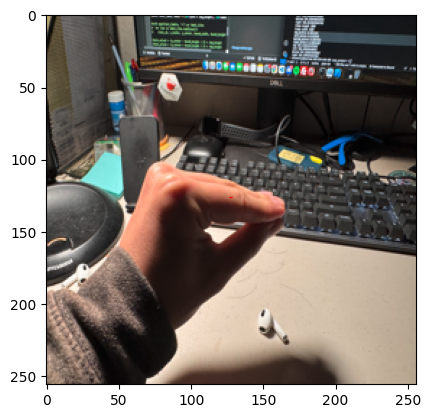

In [95]:
import matplotlib.pyplot as plt
import numpy as np
#model = tf.keras.models.load_model("new_model.keras", custom_objects={'detector': detector})
test_image = "images/combined_test/DeleteThis.png"
#test_labels = "labels/combined_test/sikharam-8-_ani_jpg.rf.18a5592f12576127a15db89ad7899e65.txt"
img = Image.open(test_image).convert("RGB")
img = img.resize((256,256))
input_tensor = tf.convert_to_tensor(np.array(img)/255.0, dtype = tf.float32)
input_tensor = tf.expand_dims(input_tensor, axis = 0)

pred_bounds = model(input_tensor)
pred_bounds = pred_bounds[0].numpy()

img_width, img_height = img.size
ymin, xmin, ymax, xmax = pred_bounds
print(pred_bounds)
print(img_width)
print(img_height)

(ymin, xmin, ymax, xmax) = (int(ymin * img_height), int(xmin * img_width), int(ymax * img_height), int(xmax * img_width))

#with open(test_labels, 'r') as label_file:
#  for line in label_file.readlines():
#    class_id, x_center, y_center, bound_width, bound_height = map(float, line.strip().split())

#ymin_actual = (y_center - bound_height / 2) * img_height
#ymax_actual = (y_center + bound_height / 2) * img_height
#xmin_actual = (x_center - bound_width / 2) * img_width
#xmax_actual = (x_center + bound_width / 2) * img_width


import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 1, edgecolor = 'r', facecolor = 'none')
#rect2 = patches.Rectangle((xmin_actual, ymin_actual), xmax_actual - xmin_actual, ymax_actual - ymin_actual, linewidth = 1, edgecolor = 'b', facecolor = 'none')
#ax.add_patch(rect2)

ax.add_patch(rect)
plt.show()

In [ ]:
model.save("mode1.keras")